Epoch 0, Loss: 42.0146
Epoch 100, Loss: 0.0080
Epoch 200, Loss: 0.0057
Epoch 300, Loss: 0.0040
Epoch 400, Loss: 0.0030
Epoch 500, Loss: 0.0019
Epoch 600, Loss: 0.0012
Epoch 700, Loss: 0.0009
Epoch 800, Loss: 0.0007
Epoch 900, Loss: 0.0006


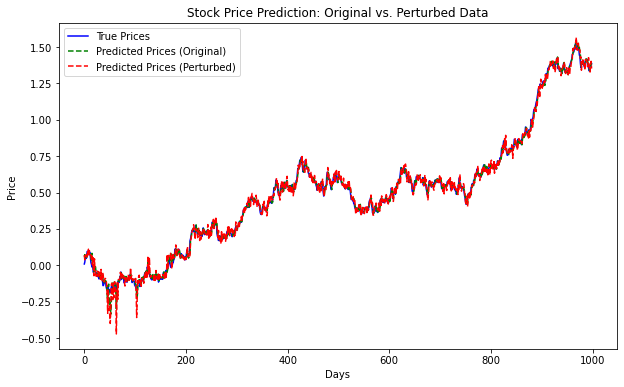

Epoch 0, Loss: 252.3293
Epoch 100, Loss: 9.0941
Epoch 200, Loss: 4.5986
Epoch 300, Loss: 2.9902
Epoch 400, Loss: 2.1809
Epoch 500, Loss: 1.7022
Epoch 600, Loss: 1.3920
Epoch 700, Loss: 1.1744
Epoch 800, Loss: 1.0168
Epoch 900, Loss: 0.8985


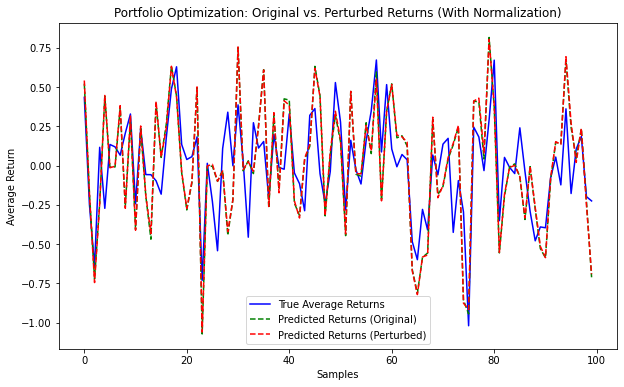

In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Set a random seed for reproducibility
np.random.seed(42)

# Module Level Docstring:
"""
This Jupyter Notebook demonstrates how perturbation theory can be applied to neural networks in financial markets.
It covers two examples:
1. Stock Price Prediction with Perturbations.
2. Portfolio Optimization with Perturbed Expected Returns.
Neural networks are built from scratch using only NumPy.
"""

# -------------------------------------------------------------
# Utility Functions for Synthetic Data Generation, Perturbations, and Normalization
# -------------------------------------------------------------

def generate_synthetic_stock_data(n_samples: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate synthetic stock price data for training the neural network.
    
    :param n_samples: The number of data points to generate.
    :return: Tuple of stock prices (features) and the next-day prices (targets).
    """
    # Simulate daily stock price data with a random walk
    stock_prices = np.cumsum(np.random.normal(loc=0.001, scale=0.02, size=n_samples))
    next_day_prices = np.roll(stock_prices, -1)  # Target is the price of the next day
    stock_prices = stock_prices[:-1]  # Remove the last element to align lengths
    next_day_prices = next_day_prices[:-1]
    
    return stock_prices.reshape(-1, 1), next_day_prices.reshape(-1, 1)

def generate_synthetic_portfolio_data(n_assets: int = 10, n_samples: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate synthetic expected returns and actual returns for a portfolio optimization task.
    
    :param n_assets: Number of assets in the portfolio.
    :param n_samples: Number of samples (historical periods).
    :return: Tuple of expected returns (features) and actual returns (targets).
    """
    expected_returns = np.random.normal(loc=0.001, scale=0.02, size=(n_samples, n_assets))
    actual_returns = expected_returns + np.random.normal(loc=0, scale=0.01, size=(n_samples, n_assets))
    
    return expected_returns, actual_returns

def apply_perturbation(data: np.ndarray, perturbation_factor: float = 0.01) -> np.ndarray:
    """
    Apply a small perturbation to the input data to simulate market noise.
    
    :param data: The input stock price data.
    :param perturbation_factor: The magnitude of the perturbation.
    :return: The perturbed stock price data.
    """
    perturbation = np.random.normal(loc=0, scale=perturbation_factor, size=data.shape)
    return data + perturbation

def normalize_data(data: np.ndarray) -> np.ndarray:
    """
    Normalize the input data to have zero mean and unit variance.
    
    :param data: The input data to normalize.
    :return: Normalized data.
    """
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# -------------------------------------------------------------
# Basic Neural Network Class (with Normalization)
# -------------------------------------------------------------

class SimpleNeuralNetwork:
    """
    A simple feedforward neural network implemented from scratch using NumPy.
    
    This network contains:
    - One input layer, one hidden layer with ReLU activation, and one output layer.
    """
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int, learning_rate: float = 0.001):
        """
        Initialize the neural network with random weights and biases.
        
        :param input_size: Number of input features.
        :param hidden_size: Number of neurons in the hidden layer.
        :param output_size: Number of output neurons.
        :param learning_rate: The learning rate for training the network.
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))
    
    def relu(self, z: np.ndarray) -> np.ndarray:
        """ReLU activation function."""
        return np.maximum(0, z)
    
    def relu_derivative(self, z: np.ndarray) -> np.ndarray:
        """Derivative of the ReLU function."""
        return np.where(z > 0, 1, 0)
    
    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Perform the forward pass through the network.
        
        :param X: Input data (features).
        :return: Output of the network.
        """
        # Hidden layer
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        
        # Output layer (no activation for regression)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        return self.Z2
    
    def backward(self, X: np.ndarray, y: np.ndarray, output: np.ndarray):
        """
        Perform the backward pass and update weights using gradient descent.
        
        :param X: Input data (features).
        :param y: True output (targets).
        :param output: Predicted output.
        """
        # Loss derivative (mean squared error)
        dZ2 = 2 * (output - y) / y.size
        
        # Gradients for output layer
        dW2 = np.dot(self.A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)
        
        # Backpropagation through the hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        
        # Gradients for hidden layer
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        
        # Update weights and biases
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
    
    def train(self, X: np.ndarray, y: np.ndarray, epochs: int = 1000):
        """
        Train the neural network using gradient descent.
        
        :param X: Training data (features).
        :param y: Training targets (true output).
        :param epochs: Number of training iterations.
        """
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)
            
            # Backward pass and weight update
            self.backward(X, y, output)
            
            # Print loss every 100 epochs
            if epoch % 100 == 0:
                loss = np.mean((output - y) ** 2)
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict output for given input data.
        
        :param X: Input data.
        :return: Predicted output.
        """
        return self.forward(X)

# -------------------------------------------------------------
# Example 1: Stock Price Prediction with Perturbations
# -------------------------------------------------------------

# Generate synthetic stock price data
stock_data, stock_target = generate_synthetic_stock_data()

# Create and train the neural network for stock price prediction
nn_stock = SimpleNeuralNetwork(input_size=1, hidden_size=64, output_size=1, learning_rate=0.01)
nn_stock.train(stock_data, stock_target, epochs=1000)

# Apply perturbations to the stock data
perturbed_stock_data = apply_perturbation(stock_data, perturbation_factor=0.02)

# Predict using original and perturbed data
predictions_original = nn_stock.predict(stock_data)
predictions_perturbed = nn_stock.predict(perturbed_stock_data)

# Visualization: Original vs. Perturbed Stock Price Predictions
plt.figure(figsize=(10, 6))
plt.plot(stock_target, label='True Prices', color='blue')
plt.plot(predictions_original, label='Predicted Prices (Original)', linestyle='--', color='green')
plt.plot(predictions_perturbed, label='Predicted Prices (Perturbed)', linestyle='--', color='red')
plt.title('Stock Price Prediction: Original vs. Perturbed Data')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# -------------------------------------------------------------
# Example 2: Portfolio Optimization with Perturbed Expected Returns
# -------------------------------------------------------------

# Generate and normalize synthetic portfolio data
portfolio_data, portfolio_target = generate_synthetic_portfolio_data()
portfolio_data = normalize_data(portfolio_data)
portfolio_target = normalize_data(portfolio_target)

# Create and train a neural network for portfolio optimization
nn_portfolio = SimpleNeuralNetwork(input_size=10, hidden_size=64, output_size=10, learning_rate=0.01)
nn_portfolio.train(portfolio_data, portfolio_target, epochs=1000)

# Apply perturbations to the expected returns
perturbed_portfolio_data = apply_perturbation(portfolio_data, perturbation_factor=0.01)

# Predict using original and perturbed data
portfolio_predictions_original = nn_portfolio.predict(portfolio_data)
portfolio_predictions_perturbed = nn_portfolio.predict(perturbed_portfolio_data)

# Visualization: Original vs. Perturbed Portfolio Returns
plt.figure(figsize=(10, 6))
plt.plot(np.mean(portfolio_target, axis=1), label='True Average Returns', color='blue')
plt.plot(np.mean(portfolio_predictions_original, axis=1), label='Predicted Returns (Original)', linestyle='--', color='green')
plt.plot(np.mean(portfolio_predictions_perturbed, axis=1), label='Predicted Returns (Perturbed)', linestyle='--', color='red')
plt.title('Portfolio Optimization: Original vs. Perturbed Returns (With Normalization)')
plt.xlabel('Samples')
plt.ylabel('Average Return')
plt.legend()
plt.show()


# Detailed Explanation of the Code

This Jupyter Notebook implements a neural network from scratch using NumPy for two financial applications: stock price prediction and portfolio optimization with perturbations. The neural network is designed to predict values based on synthetic financial data, and the purpose of the notebook is to show how small perturbations in input data can affect the network’s predictions.

## Code Breakdown:

### 1. Synthetic Data Generation:
   - **Stock Price Data Generation**: For stock price prediction, synthetic stock data is generated using a random walk, where each day's stock price is a small deviation from the previous day's price. The generated data represents a typical time series of stock prices, and the task is to predict the next day's price.
   - **Portfolio Data Generation**: In the portfolio optimization task, synthetic data is generated for a portfolio of assets. The data includes expected returns and actual returns for multiple assets over a set number of historical periods. The goal is to optimize the portfolio based on the relationship between expected and actual returns.
   - **Perturbations**: A key part of this notebook is the introduction of perturbations (small changes) to the input data. This simulates real-world market noise or minor unexpected changes in financial data. The function `apply_perturbation` adds a small Gaussian noise to the data to create perturbed versions of the original data.

### 2. Normalization:
   - **Why Normalize?** Neural networks typically perform better when input data is normalized (mean of 0 and standard deviation of 1). This ensures that the learning process is stable and that the network doesn’t get biased towards features with larger scales. The `normalize_data` function normalizes the input data, ensuring that all features are on the same scale.
   
### 3. Simple Neural Network from Scratch:
   - **Architecture**: The neural network class `SimpleNeuralNetwork` implements a basic feedforward neural network with:
     - One input layer (with a number of features defined by the input size).
     - One hidden layer using ReLU (Rectified Linear Unit) as the activation function.
     - One output layer (for regression tasks such as predicting stock prices or portfolio returns).
   
   - **Forward Pass**: The `forward` method calculates the output by propagating the input through the hidden layer and then through the output layer. The ReLU function is used as the activation function in the hidden layer, which helps the network learn non-linear relationships in the data.
   
   - **Backward Pass (Backpropagation)**: The `backward` method computes the gradient of the loss function (Mean Squared Error) with respect to the weights and biases, and then updates them using gradient descent. This ensures that the network learns to minimize the prediction error over time.
   
   - **Training**: The `train` method iterates through multiple epochs, during each of which it performs a forward pass, calculates the loss, and performs backpropagation to update the weights and biases. Loss is printed every 100 epochs to track the progress of training.
   
### 4. Predictions:
   - After training the neural network, predictions are made on both the original and perturbed data using the `predict` method. This demonstrates how sensitive the network’s predictions are to small changes (perturbations) in the input data.
   
### 5. Visualization:
   - The results are visualized using `matplotlib`, where we plot the true values, the predicted values from the original data, and the predicted values from the perturbed data. This helps to visually compare the effects of perturbations on the network's predictions.
   - A legend is added to the plot for clarity, showing which line represents the true values, the original predictions, and the perturbed predictions.

### 6. Portfolio Optimization Example:
   - In the second example, we apply the same neural network architecture to a portfolio optimization problem. The network is tasked with learning the relationship between expected returns and actual returns for a set of assets. After training, we perturb the expected returns to simulate market noise and see how the predictions for portfolio returns change. The results are plotted to show the differences between original and perturbed predictions.

### Key Takeaways:
   - **Perturbation Sensitivity**: This notebook demonstrates the sensitivity of neural networks to small changes in input data (perturbations), which can lead to significantly different predictions in financial models.
   - **Normalization**: Data normalization is crucial for ensuring that the network trains efficiently and avoids biasing the learning process towards features with larger ranges.
   - **Backpropagation and Learning**: The network’s learning process is based on gradient descent, and the backpropagation algorithm ensures that the network minimizes the error over time by updating its weights and biases.
   - **Interpretation of Results**: Visualizing the original and perturbed predictions helps understand how resilient (or sensitive) the network is to small changes in input data, which is critical for financial applications like trading systems or portfolio management.
